In [1]:
# Install the required packages
# !pip install -q yfinance==0.2.44 # Version 0.2.45 (lastest as of 2024-10-21) has an import error.
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q holoviews

In [2]:
# Import in-house modules from the 'utilities' package
from utilities import calculate_bollinger_bands, calculate_rsi, calculate_daily_volatility
from utilities import print_title, print_label, print_footer
from utilities import generate_trading_signals
from utilities import fetch_and_download_sp500_data, sp500_data_for_today
from utilities import print_dataframe_report, save_data

In [3]:
# Import libraries for data analysis and visualization
import pandas as pd

# Import libraries for signal processing and peak detection
from scipy.signal import find_peaks
import numpy as np

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

# Import libraries for data storage and retrieval
from pathlib import Path

In [4]:
# Set display options for Pandas (optional, but often helpful)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Suppress scientific notation

### Data Collection
___

In [5]:
# Syntax: fetch_and_download_sp500_data(start_date="YYYY-MM-DD", end_date="YYYY-MM-DD")
# To add an end date, put end_date="YYYY-MM-DD"

data = fetch_and_download_sp500_data(start_date="2023-10-24")

[*********************100%***********************]  501 of 501 completed

2 Failed downloads:
['J', 'LRCX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-10-24 -> 2024-10-21)')


╔═══════════════════════════════════════════════════════════════╗
║            Download Report for S&P 500 `adj close`            ║
╠═══════════════════════════════════════════════════════════════╣
║ Total Requested Tickers:       |             501              ║
║ Total Downloaded Tickers:      |             501              ║
║ Requested Date Range:          |   2023-10-24 to 2024-10-21   ║
║ Downloaded Date Range:         |   2023-10-24 to 2024-10-18   ║
║                       S&P 500 Data Downloaded Successfully... ║
╚═══════════════════════════════════════════════════════════════╝


In [6]:
# Syntax: sp500_data_for_today(time="15:59:00"):
# The default time is 15:59:00, which is the last minute of the trading day (3:59 PM)
# The time must be in the format "HH:MM:SS"

todays_data = sp500_data_for_today(time="15:59:00")

╔═══════════════════════════════════════════════════════════════╗
║      Download Report for S&P 500  `close` for 2024-10-21      ║
╠═══════════════════════════════════════════════════════════════╣
║ Total Requested Tickers:       |             501              ║
║ Requested Time:                |           15:59:00           ║
║ Downloaded Date:               |          2024-10-21          ║
║                       S&P 500 Data Downloaded Successfully... ║
╚═══════════════════════════════════════════════════════════════╝


In [7]:
data = pd.concat([data, todays_data], axis=0)

print("Shape:", data.shape)
data.tail(15)

Shape: (250, 501)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-10-01 00:00:00+00:00,146.560,226.210,195.400,125.470,113.027,113.510,350.553,502.800,223.670,59.520,...,300.580,33.700,99.450,65.320,119.930,134.390,139.240,107.340,364.300,194.420
2024-10-02 00:00:00+00:00,146.540,226.780,195.261,126.180,113.107,113.740,354.846,505.810,227.730,58.790,...,295.410,33.620,102.040,65.150,121.520,134.380,139.540,105.690,368.680,192.460
2024-10-03 00:00:00+00:00,144.550,225.670,193.902,125.290,111.704,112.850,359.776,503.800,226.560,58.470,...,290.590,32.930,103.080,64.400,122.580,133.060,137.210,104.190,363.890,190.990
2024-10-04 00:00:00+00:00,144.970,226.800,192.751,129.850,112.112,114.860,360.772,507.220,228.230,59.230,...,290.690,32.880,105.450,63.730,124.830,133.470,136.570,104.680,366.720,190.030
2024-10-07 00:00:00+00:00,143.890,221.690,192.076,130.230,112.828,107.790,355.354,487.300,226.510,58.860,...,287.990,32.850,106.410,63.010,125.370,134.030,135.880,102.280,365.240,187.280
2024-10-08 00:00:00+00:00,144.610,225.770,191.481,132.500,114.092,109.910,358.919,496.240,229.400,57.550,...,292.940,33.110,102.880,62.930,122.040,134.200,134.720,101.770,368.970,187.370
2024-10-09 00:00:00+00:00,144.800,229.540,193.207,135.490,115.406,113.090,363.600,494.080,233.240,56.970,...,298.050,33.060,104.150,62.580,122.090,136.290,134.760,103.460,373.500,190.170
2024-10-10 00:00:00+00:00,142.740,229.040,192.810,132.810,115.078,113.900,361.070,503.570,230.700,57.290,...,290.240,32.630,103.700,62.160,123.140,134.170,133.270,102.820,369.240,190.280
2024-10-11 00:00:00+00:00,143.820,227.550,192.652,134.400,115.575,114.400,360.740,495.420,232.860,57.970,...,290.030,33.030,104.750,62.310,123.610,136.860,134.020,103.500,375.020,190.080
2024-10-14 00:00:00+00:00,144.250,231.300,194.100,134.790,116.700,111.090,364.600,509.650,236.430,57.910,...,292.650,32.590,103.950,63.020,124.080,137.240,134.650,104.830,377.680,192.650


### Feature Engineering
___

In [8]:
upper_band, lower_band = calculate_bollinger_bands(data)

forecast_horizon = 1
returns = data.pct_change().copy()
returns = returns.shift(-forecast_horizon)

# Create a dictionary of feature dataframes
feature_dataframes = {
    # Returns and Volatility Calculations
    "returns": returns,
    "daily_volatility": data.apply(calculate_daily_volatility).copy(),

    # Technical Indicators
    "rsi": data.apply(calculate_rsi).copy(),
    "sma_50": data.rolling(window=50).mean().copy(),
    "sma_100": data.rolling(window=100).mean().copy(),
    "sma_200": data.rolling(window=200).mean().copy(),
    "upper_band": upper_band.copy(),
    "lower_band": lower_band.copy(),

    # Support and Resistance Levels
    "support": data.rolling(window=50).min().copy(),
    "resistance": data.rolling(window=50).max().copy(),

    # Trading Signals
    "actions": data.apply(generate_trading_signals).copy()
}

In [9]:
# Inspect DataFrames
select_df = "lower_band"

inspect_df = feature_dataframes[select_df].copy()

print_dataframe_report(inspect_df, select_df)
inspect_df.head()

╔═══════════════════════════════════════════════════════════════╗
║                 `Lower_band` DataFrame Report                 ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   | 2023-10-24 00:00:00+00:00 to 2024-10-21 15:59:00-04:00 ║
║ `Lower_band` Data Types:       |      [dtype('float64')]      ║
║ `Lower_band` DF Shape:         |          (250, 501)          ║
║ Columns with null values:      |             501              ║
║ Rows with null values:         |              19              ║
║ Total Unique Values:           |            114676            ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-27 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing
___

In [10]:
# Initialize an empty dictionary for clean dataframes
clean_feature_dataframes = {}

for key, df in feature_dataframes.items():
    
    # Perform forward and backward filling, and then fill remaining NaNs with 0 or mean
    filled_df = df.copy()
    filled_df.ffill(inplace=True)
    filled_df.bfill(inplace=True)
    
    # Store the cleaned dataframe in the new dictionary
    clean_feature_dataframes[key] = filled_df

In [11]:
# Inspect DataFrames
select_df = "lower_band"

inspect_df = clean_feature_dataframes[select_df]

print_dataframe_report(inspect_df, select_df)
inspect_df.head()

╔═══════════════════════════════════════════════════════════════╗
║                 `Lower_band` DataFrame Report                 ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   | 2023-10-24 00:00:00+00:00 to 2024-10-21 15:59:00-04:00 ║
║ `Lower_band` Data Types:       |      [dtype('float64')]      ║
║ `Lower_band` DF Shape:         |          (250, 501)          ║
║ Columns with null values:      |              0               ║
║ Rows with null values:         |              0               ║
║ Total Unique Values:           |            114676            ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-25 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-26 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-27 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-30 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565


### Exploratory Data Analysis (EDA):
___

In [12]:
for name, df in clean_feature_dataframes.items():
    print_title(f"`{name}` DataFrame", closed_corners=False)
    print_label("Shape:", f"{df.shape}")
    print_label("Length:", f"{len(df)}", closed_corners=True)

    display(df.head())

╔═══════════════════════════════════════════════════════════════╗
║                      `returns` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,-0.021,-0.013,-0.007,-0.029,-0.013,0.001,-0.012,-0.034,-0.031,0.023,...,-0.001,-0.011,-0.027,0.007,0.002,-0.019,0.003,-0.011,-0.034,-0.021
2023-10-25 00:00:00+00:00,0.009,-0.025,-0.000,-0.026,0.004,-0.012,-0.002,-0.013,0.007,0.011,...,0.103,0.014,-0.016,0.005,-0.009,0.011,-0.013,-0.005,0.030,-0.034
2023-10-26 00:00:00+00:00,-0.015,0.008,-0.043,-0.012,-0.012,-0.013,-0.007,-0.012,-0.002,-0.025,...,-0.001,-0.013,-0.003,-0.024,-0.019,-0.006,0.006,0.001,0.011,-0.013
2023-10-27 00:00:00+00:00,-0.016,0.012,0.021,0.025,0.002,0.019,0.009,0.037,-0.029,0.020,...,0.017,-0.002,0.009,0.007,0.003,0.012,0.004,0.002,0.013,0.006
2023-10-30 00:00:00+00:00,0.022,0.003,-0.005,0.011,0.017,0.046,0.015,0.010,0.009,0.002,...,0.013,0.005,-0.003,0.009,-0.000,0.048,0.008,0.010,-0.002,0.002


╔═══════════════════════════════════════════════════════════════╗
║                 `daily_volatility` DataFrame                  ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,0.410,0.188,0.209,0.457,0.170,0.332,0.169,0.304,0.294,0.169,...,0.364,0.322,0.351,0.209,0.205,0.237,0.145,0.251,0.443,0.339
2023-10-25 00:00:00+00:00,0.410,0.188,0.209,0.457,0.170,0.332,0.169,0.304,0.294,0.169,...,0.364,0.322,0.351,0.209,0.205,0.237,0.145,0.251,0.443,0.339
2023-10-26 00:00:00+00:00,0.410,0.188,0.209,0.457,0.170,0.332,0.169,0.304,0.294,0.169,...,0.364,0.322,0.351,0.209,0.205,0.237,0.145,0.251,0.443,0.339
2023-10-27 00:00:00+00:00,0.410,0.188,0.209,0.457,0.170,0.332,0.169,0.304,0.294,0.169,...,0.364,0.322,0.351,0.209,0.205,0.237,0.145,0.251,0.443,0.339
2023-10-30 00:00:00+00:00,0.410,0.188,0.209,0.457,0.170,0.332,0.169,0.304,0.294,0.169,...,0.364,0.322,0.351,0.209,0.205,0.237,0.145,0.251,0.443,0.339


╔═══════════════════════════════════════════════════════════════╗
║                        `rsi` DataFrame                        ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,100.000,...,0.000,0.000,0.000,100.000,100.000,0.000,100.000,0.000,0.000,0.000
2023-10-25 00:00:00+00:00,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,100.000,...,0.000,0.000,0.000,100.000,100.000,0.000,100.000,0.000,0.000,0.000
2023-10-26 00:00:00+00:00,28.889,0.000,0.000,0.000,24.849,6.306,0.000,0.000,17.230,100.000,...,99.302,54.795,0.000,100.000,16.806,35.632,20.408,0.000,45.820,0.000
2023-10-27 00:00:00+00:00,19.403,16.878,0.000,0.000,14.749,3.182,0.000,0.000,16.462,56.802,...,98.568,35.714,0.000,32.093,6.173,29.712,41.132,3.911,54.158,0.000
2023-10-30 00:00:00+00:00,14.467,34.171,28.627,26.531,19.113,42.742,30.540,37.445,9.562,67.504,...,98.785,33.613,16.194,43.411,14.846,47.990,49.351,14.428,60.806,8.043


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_50` DataFrame                       ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,121.678,186.476,140.884,130.258,100.178,81.133,323.427,588.774,178.649,71.000,...,235.704,30.889,87.525,58.683,100.301,102.344,124.428,112.546,233.602,178.187
2023-10-25 00:00:00+00:00,121.678,186.476,140.884,130.258,100.178,81.133,323.427,588.774,178.649,71.000,...,235.704,30.889,87.525,58.683,100.301,102.344,124.428,112.546,233.602,178.187
2023-10-26 00:00:00+00:00,121.678,186.476,140.884,130.258,100.178,81.133,323.427,588.774,178.649,71.000,...,235.704,30.889,87.525,58.683,100.301,102.344,124.428,112.546,233.602,178.187
2023-10-27 00:00:00+00:00,121.678,186.476,140.884,130.258,100.178,81.133,323.427,588.774,178.649,71.000,...,235.704,30.889,87.525,58.683,100.301,102.344,124.428,112.546,233.602,178.187
2023-10-30 00:00:00+00:00,121.678,186.476,140.884,130.258,100.178,81.133,323.427,588.774,178.649,71.000,...,235.704,30.889,87.525,58.683,100.301,102.344,124.428,112.546,233.602,178.187


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_100` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,128.301,184.512,154.118,140.167,106.883,82.533,343.500,586.095,184.380,63.564,...,247.917,31.886,93.078,57.239,100.705,110.781,128.032,118.179,248.845,183.461
2023-10-25 00:00:00+00:00,128.301,184.512,154.118,140.167,106.883,82.533,343.500,586.095,184.380,63.564,...,247.917,31.886,93.078,57.239,100.705,110.781,128.032,118.179,248.845,183.461
2023-10-26 00:00:00+00:00,128.301,184.512,154.118,140.167,106.883,82.533,343.500,586.095,184.380,63.564,...,247.917,31.886,93.078,57.239,100.705,110.781,128.032,118.179,248.845,183.461
2023-10-27 00:00:00+00:00,128.301,184.512,154.118,140.167,106.883,82.533,343.500,586.095,184.380,63.564,...,247.917,31.886,93.078,57.239,100.705,110.781,128.032,118.179,248.845,183.461
2023-10-30 00:00:00+00:00,128.301,184.512,154.118,140.167,106.883,82.533,343.500,586.095,184.380,63.564,...,247.917,31.886,93.078,57.239,100.705,110.781,128.032,118.179,248.845,183.461


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_200` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,133.160,189.938,160.623,145.392,106.051,89.672,327.015,545.511,199.293,62.232,...,254.636,31.284,92.514,55.541,107.702,122.673,131.269,116.920,278.952,176.718
2023-10-25 00:00:00+00:00,133.160,189.938,160.623,145.392,106.051,89.672,327.015,545.511,199.293,62.232,...,254.636,31.284,92.514,55.541,107.702,122.673,131.269,116.920,278.952,176.718
2023-10-26 00:00:00+00:00,133.160,189.938,160.623,145.392,106.051,89.672,327.015,545.511,199.293,62.232,...,254.636,31.284,92.514,55.541,107.702,122.673,131.269,116.920,278.952,176.718
2023-10-27 00:00:00+00:00,133.160,189.938,160.623,145.392,106.051,89.672,327.015,545.511,199.293,62.232,...,254.636,31.284,92.514,55.541,107.702,122.673,131.269,116.920,278.952,176.718
2023-10-30 00:00:00+00:00,133.160,189.938,160.623,145.392,106.051,89.672,327.015,545.511,199.293,62.232,...,254.636,31.284,92.514,55.541,107.702,122.673,131.269,116.920,278.952,176.718


╔═══════════════════════════════════════════════════════════════╗
║                    `upper_band` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,115.268,194.716,141.142,130.042,98.489,88.519,332.040,633.693,182.682,72.921,...,251.154,31.734,93.595,59.203,105.645,103.654,128.054,112.220,221.302,179.581
2023-10-25 00:00:00+00:00,115.268,194.716,141.142,130.042,98.489,88.519,332.040,633.693,182.682,72.921,...,251.154,31.734,93.595,59.203,105.645,103.654,128.054,112.220,221.302,179.581
2023-10-26 00:00:00+00:00,115.268,194.716,141.142,130.042,98.489,88.519,332.040,633.693,182.682,72.921,...,251.154,31.734,93.595,59.203,105.645,103.654,128.054,112.220,221.302,179.581
2023-10-27 00:00:00+00:00,115.268,194.716,141.142,130.042,98.489,88.519,332.040,633.693,182.682,72.921,...,251.154,31.734,93.595,59.203,105.645,103.654,128.054,112.220,221.302,179.581
2023-10-30 00:00:00+00:00,115.268,194.716,141.142,130.042,98.489,88.519,332.040,633.693,182.682,72.921,...,251.154,31.734,93.595,59.203,105.645,103.654,128.054,112.220,221.302,179.581


╔═══════════════════════════════════════════════════════════════╗
║                    `lower_band` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-25 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-26 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-27 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565
2023-10-30 00:00:00+00:00,98.748,162.902,130.636,111.039,89.118,80.839,279.191,499.036,148.601,67.322,...,211.525,26.812,82.194,55.824,98.552,85.223,115.357,99.648,196.077,149.565


╔═══════════════════════════════════════════════════════════════╗
║                      `support` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,100.489,166.040,132.747,114.090,91.033,73.420,285.451,508.120,153.207,67.266,...,205.041,27.723,81.536,56.106,95.595,86.761,116.446,102.266,197.990,150.310
2023-10-25 00:00:00+00:00,100.489,166.040,132.747,114.090,91.033,73.420,285.451,508.120,153.207,67.266,...,205.041,27.723,81.536,56.106,95.595,86.761,116.446,102.266,197.990,150.310
2023-10-26 00:00:00+00:00,100.489,166.040,132.747,114.090,91.033,73.420,285.451,508.120,153.207,67.266,...,205.041,27.723,81.536,56.106,95.595,86.761,116.446,102.266,197.990,150.310
2023-10-27 00:00:00+00:00,100.489,166.040,132.747,114.090,91.033,73.420,285.451,508.120,153.207,67.266,...,205.041,27.723,81.536,56.106,95.595,86.761,116.446,102.266,197.990,150.310
2023-10-30 00:00:00+00:00,100.489,166.040,132.747,114.090,91.033,73.420,285.451,508.120,153.207,67.266,...,205.041,27.723,81.536,56.106,95.595,86.761,116.446,102.266,197.990,150.310


╔═══════════════════════════════════════════════════════════════╗
║                    `resistance` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,138.878,197.361,155.766,147.500,108.809,90.000,348.842,633.660,198.366,74.454,...,244.383,34.289,94.086,61.881,105.414,113.448,129.175,120.933,275.790,198.597
2023-10-25 00:00:00+00:00,138.878,197.361,155.766,147.500,108.809,90.000,348.842,633.660,198.366,74.454,...,244.383,34.289,94.086,61.881,105.414,113.448,129.175,120.933,275.790,198.597
2023-10-26 00:00:00+00:00,138.878,197.361,155.766,147.500,108.809,90.000,348.842,633.660,198.366,74.454,...,244.383,34.289,94.086,61.881,105.414,113.448,129.175,120.933,275.790,198.597
2023-10-27 00:00:00+00:00,138.878,197.361,155.766,147.500,108.809,90.000,348.842,633.660,198.366,74.454,...,244.383,34.289,94.086,61.881,105.414,113.448,129.175,120.933,275.790,198.597
2023-10-30 00:00:00+00:00,138.878,197.361,155.766,147.500,108.809,90.000,348.842,633.660,198.366,74.454,...,244.383,34.289,94.086,61.881,105.414,113.448,129.175,120.933,275.790,198.597


╔═══════════════════════════════════════════════════════════════╗
║                      `actions` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |          (250, 501)          ║
║ Length:                        |             250              ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2023-10-24 00:00:00+00:00,buy,short,short,short,buy,sell,short,short,buy,hold,...,buy,buy,short,hold,sell,buy,sell,short,buy,short
2023-10-25 00:00:00+00:00,buy,short,short,short,buy,sell,short,short,buy,hold,...,buy,buy,short,hold,sell,buy,sell,short,buy,short
2023-10-26 00:00:00+00:00,sell,buy,short,short,sell,short,short,short,sell,sell,...,sell,sell,short,sell,short,sell,buy,buy,hold,short
2023-10-27 00:00:00+00:00,short,hold,buy,buy,buy,buy,buy,buy,short,buy,...,buy,short,buy,buy,buy,buy,hold,hold,hold,buy
2023-10-30 00:00:00+00:00,buy,hold,sell,hold,hold,hold,hold,hold,buy,hold,...,hold,buy,sell,hold,sell,hold,hold,hold,sell,hold


### Merging S&P Data
___

In [23]:
# Assign clean dataframes to individual variables for easier access

# Returns and Volatility Calculations
returns = clean_feature_dataframes["returns"]
daily_volatility = clean_feature_dataframes["daily_volatility"]

# Technical Indicators
rsi = clean_feature_dataframes["rsi"]
sma_50 = clean_feature_dataframes["sma_50"]
sma_100 = clean_feature_dataframes["sma_100"]
sma_200 = clean_feature_dataframes["sma_200"]
upper_band = clean_feature_dataframes["upper_band"]
lower_band = clean_feature_dataframes["lower_band"]

# Support and Resistance Levels
support = clean_feature_dataframes["support"]
resistance = clean_feature_dataframes["resistance"]

# Trading Signals
actions = clean_feature_dataframes["actions"]

In [24]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Display DataFrame
print_title(f"`indicators_df` Shape: {indicators_df.shape}")
display(indicators_df.head())
display(indicators_df.tail())

╔═══════════════════════════════════════════════════════════════╗
║              `indicators_df` Shape: (124109, 14)              ║
╚═══════════════════════════════════════════════════════════════╝


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2023-10-24 00:00:00+00:00,A,104.928,-0.021,0.410,0.000,121.678,128.301,133.160,115.268,98.748,100.489,138.878,buy
1,2023-10-24 00:00:00+00:00,AAPL,172.557,-0.013,0.188,0.000,186.476,184.512,189.938,194.716,162.902,166.040,197.361,short
2,2023-10-24 00:00:00+00:00,ABBV,141.150,-0.007,0.209,0.000,140.884,154.118,160.623,141.142,130.636,132.747,155.766,short
3,2023-10-24 00:00:00+00:00,ABNB,122.010,-0.029,0.457,0.000,130.258,140.167,145.392,130.042,111.039,114.090,147.500,short
4,2023-10-24 00:00:00+00:00,ABT,92.955,-0.013,0.170,0.000,100.178,106.883,106.051,98.489,89.118,91.033,108.809,buy


In [25]:
# Export to a new CSV file
file_name = f"sp500_adj_close_raw.csv"
file_path = f"data/raw_data/{file_name}"

# save_data(indicators_df, file_path)

╔═══════════════════════════════════════════════════════════════╗
║File `sp500_adj_close_raw.zip` already exists. Overwriting file.║
╚═══════════════════════════════════════════════════════════════╝
╔═══════════════════════════════════════════════════════════════╗
║      File saved and zipped as `sp500_adj_close_raw.zip`       ║
╚═══════════════════════════════════════════════════════════════╝


### Data Visualization
___

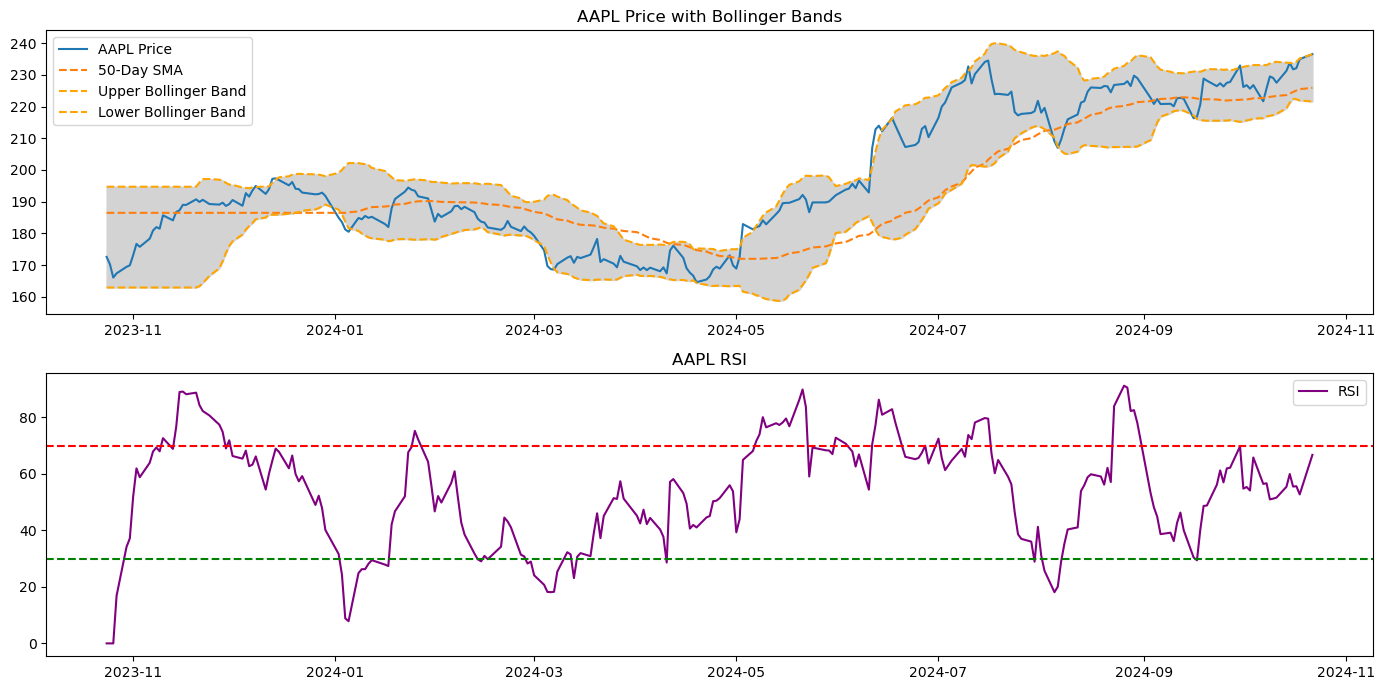

In [16]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [17]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [index]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [index]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [index]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]

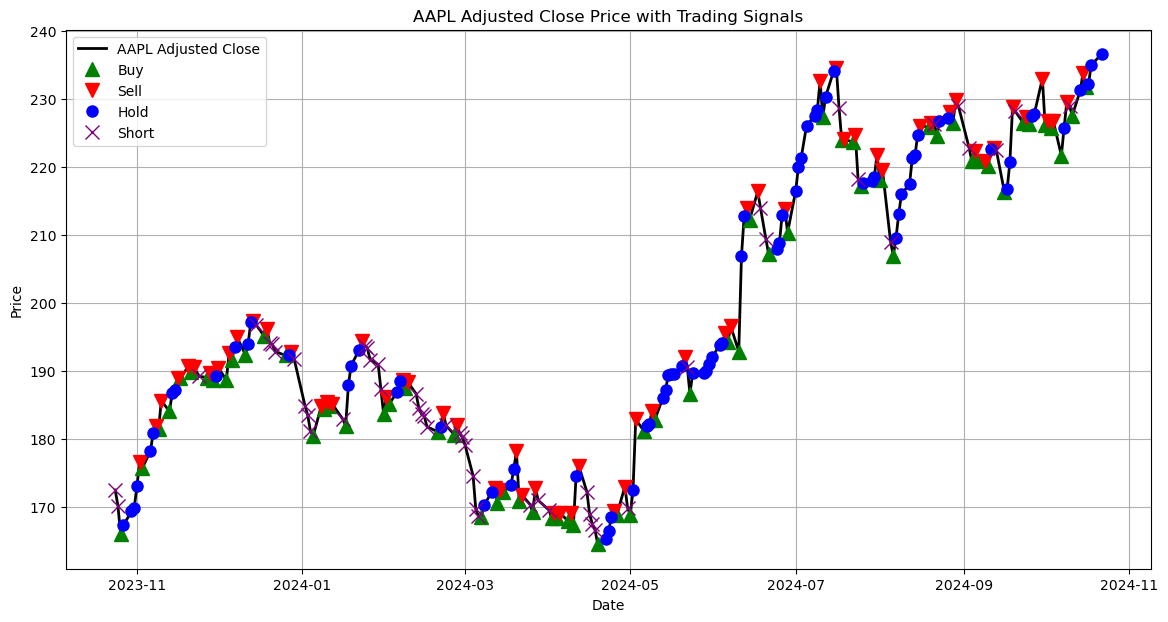

In [18]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


:Overlay
   .Curve.I       :Curve   [index]   (AAPL)
   .Scatter.Buy   :Scatter   [index]   (AAPL)
   .Scatter.Sell  :Scatter   [index]   (AAPL)
   .Scatter.Hold  :Scatter   [index]   (AAPL)
   .Scatter.Short :Scatter   [index]   (AAPL)